# **Orieentiring_GA: genetic algorithm for orieenting**

Libraries import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [88]:
class Individual:

  '''
  This class represent an individual in the population for the GA
  
  Attributes:
    - path: a list that is used for storing the direction of the path
    - fitness: a variable used for saving the value of the fitness of the individual
  '''

  def __init__(self):
    '''
    Constructor of the Individual class: path is initialized as an empty list
                                         while fitness is initialized as 0 
    '''
    self.path = []
    self.fitness = 0
    self.number_of_cp_reached = 0
    self.cp_index = {0:0}

  def getPath(self):
    # this method is used to retrieve the path of the individual 
    return self.path

  def getFitness(self):
    # this method is used to retrieve the fitness of the individual
    return self.fitness

  def compass(self,current_point,control_point):
    
    if current_point[0] >= control_point[0] and current_point[1] >= control_point[1]:
      direction1 = 0
      direction2 = 1
    elif current_point[0] >= control_point[0] and current_point[1] <= control_point[1]:
      direction1 = 1
      direction2 = 2
    elif current_point[0] <= control_point[0] and current_point[1] <= control_point[1]:
      direction1 = 2
      direction2 = 3
    elif current_point[0] <= control_point[0] and current_point[1] >= control_point[1]:
      direction1 = 0
      direction2 = 3


    return direction1, direction2

  def __repr__(self):
        return "(Path: " + str(self.path) + ", fitness: " + str(self.fitness) + ", number_of_cp_reached: "+ str(self.number_of_cp_reached) + ", cp_index: " + str(self.cp_index) + ")"

In [3]:
class Map:

  '''
  This class is used to create the map where the Orieentiring take place:
  it is a mxn array (m and n are given as parameter) where a certain number of
  obstacles and control points are placed.

  Attributes:
    - rows: the number of rows of the map (the m dimension)
    - colums: the numbers of the map (the n dimension)
    - number_of_obstacles: the number of obstacles that will appear on the map
    - number_of_cp: number of control points that will appear on the map
    - cp_list: a list containing all the coordinates of the control points. 
               Initially contains the start point at (0,0)
  '''

  def __init__(self, rows, columns, number_of_obstacles, number_of_cp):

    '''
    The constructor of the map: lenght and height represent the dimension of the map (array)
    while number_of_obstacles and number_of_cp represent the number of obstacles and the number
    of control points that will be placed on the map, respectively.
    '''

    self.rows = rows
    self.columns = columns
    self.number_of_obstacles = number_of_obstacles
    self.number_of_cp = number_of_cp
    self.cp_list = []

  def create_map(self):

    '''
    This method is used to fill the array: the 'walkable ground' will be the cells that contains 0, the obstacle
    will be the cells containing 1 and the control points will be the cells containg 2, including the start and
    ending points. 
    '''

    map = np.zeros((self.rows, self.columns)) #initially, we create the array with all 0s

    for i in range(self.number_of_obstacles): # iterate over the number of obstacles 

      #randomically, create the coordinates where to put the obstacle
      x_obstacle = np.random.randint(0,self.rows)
      y_obstacle = np.random.randint(0,self.columns)
      #print('Posizione ostacolo: {0}, {1}'.format(x_ostacolo,y_ostacolo))

      #check if the coordinate corresponds with a control point, the start or the end
      if map[x_obstacle][y_obstacle] == 2:
        #if true, do not place the obstacle
        continue
      else:
        #else, put the obstacle
        map[x_obstacle][y_obstacle] = 1
      
      #next, place the control point, if any remain to be placed
      if self.number_of_cp != 0:
        
        #randomically, create the coordinates where to put the control point
        x_cp = np.random.randint(0,self.rows)
        y_cp = np.random.randint(0,self.columns)
        
        #check if the control point is over an obstacle
        if map[x_cp][y_cp] == 1:
          #if true, do not put the control point
          continue
        else: 
          map[x_cp][y_cp] = 2 # put the control point
          self.cp_list.append([x_cp,y_cp]) # add the coordinate to the list of all control points
          self.number_of_cp -= 1 # reduce the number of control points

    #self.cp_list.append([self.lenght-1,self.height-1]) # in the end, add the arrival point to the list of control points

    probability = np.random.uniform(0,1,1)

    if probability >= 0.5:
      self.cp_list.sort(key = lambda point: point[1])
    else:
      self.cp_list.sort()

    return map, self.cp_list # return the array and the list
    

  def getControlPointList(self):

    # this method is used for obtain the list of control points
    return self.cp_list

  def visualizeMap(self,map):

    '''
    this method is used for plotting the map
    '''
    # set the dimension of the plot
    plt.figure(figsize=(12,12))

    #use a heatmap for plotting, so the same value will have the same color
    ax = sns.heatmap(map, cbar = False, cmap = sns.color_palette("coolwarm", 12),linewidth = 1)

    # get the x and y coordinate for each point, and sum 0.5, so the line will start at the centre of the square
    x = [self.cp_list[i][1] + 0.5 for i in range(len(self.cp_list))]
    y = [self.cp_list[i][0] + 0.5 for i in range(len(self.cp_list))]

    #plot the lines
    plt.plot(x, y, 'ro-')

    #add text near the point
    plt.text(x[0] - 0.15, y[0] - 0.15, 'Start')
    for i in range(1,len(x)-1):
      plt.text(x[i] + 0.15, y[i] + 0.15, str(i))
    plt.text(x[-1] - 0.20, y[-1] - 0.20, 'End')

    ax.invert_yaxis()

    plt.ylim(0,self.rows)
    plt.xlim(0,self.columns)

    #show the plot
    plt.show()

  def visualizeIndividual(self, map, individual):
    
    copia = map.copy()
    moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
    point = self.getControlPointList()[0]
    
    for m in individual.path:
      point = [point[0] + moves[m][0], point[1] + moves[m][1]]
      
      if point[0] >= self.rows or point[1] >= self.columns or point[0] < 0 or point[1] < 0:
        point = [point[0] - moves[m][0], point[1] - moves[m][1]]
        continue

      if copia[point[0]][point[1]] == 2:
        continue
      else:
        copia[point[0]][point[1]] = 3

    plt.figure(figsize=(12,12))

    ax = sns.heatmap(copia, cbar = False, cmap = sns.color_palette("coolwarm", 12),linewidth = 1)
    ax.invert_yaxis()

    x = [self.cp_list[i][1] + 0.5 for i in range(len(self.cp_list))]
    y = [self.cp_list[i][0] + 0.5 for i in range(len(self.cp_list))]

    #plot the lines
    plt.plot(x, y, 'ro-')

    #add text near the point
    plt.text(x[0] - 0.25, y[0] - 0.25, 'Start')
    for i in range(1,len(x)-1):
      plt.text(x[i] + 0.15, y[i] + 0.15, str(i))
    plt.text(x[-1] - 0.20, y[-1] - 0.20, 'End')

    plt.ylim(0,self.rows)
    plt.xlim(0,self.columns)

    #show the plot
    plt.show()

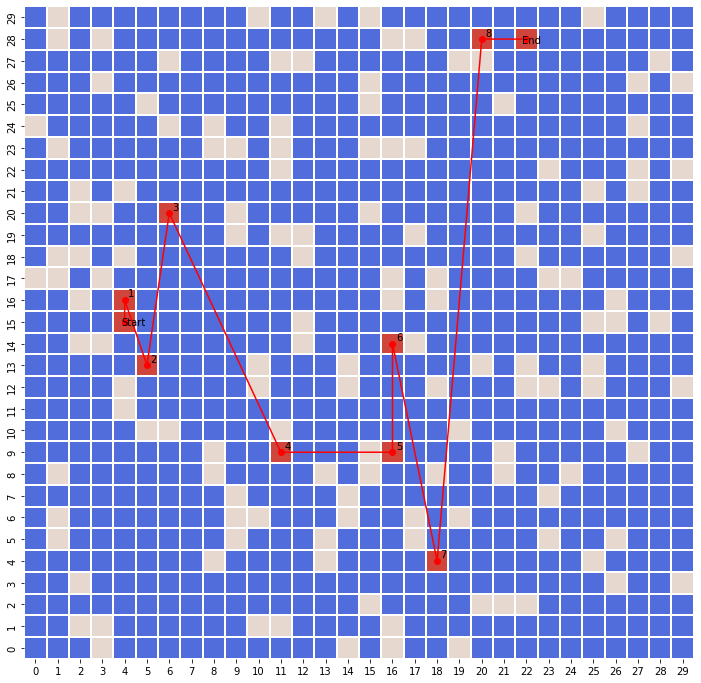

In [4]:
map = Map(30,30,150,10)
mappa, lanterne = map.create_map()
map.visualizeMap(mappa)

In [5]:
cp_list = map.getControlPointList()
cp_list

[[15, 4],
 [16, 4],
 [13, 5],
 [20, 6],
 [9, 11],
 [9, 16],
 [14, 16],
 [4, 18],
 [28, 20],
 [28, 22]]

In [6]:
def getNumberOfStepBetweenPoits(p1, p2):

  return (abs(p1[0] - p2[0])) + abs((p1[1] - p2[1]))

In [7]:
def getTotalNumberOfSteps(list_of_point):
  total_steps = 0
  for i in range(0,len(list_of_point)-1):

    total_steps += getNumberOfStepBetweenPoits(list_of_point[i],list_of_point[i+1])

  return total_steps

In [8]:
def avoid_obstacle(moves, current_point, movement):

  found = False
  current_point = [current_point[0] - movement[0], current_point[1] - movement[1]]
  remain_moves = moves.copy()
  remain_moves.remove(movement)

  for points in remain_moves:
    point = [current_point[0] + points[0], current_point[1] + points[1]]

    if checkOutOfMap(point):
      continue

    if mappa[point[0]][point[1]] == 1:
      continue
    else:
      current_point = point
      found = True
      return current_point, found, points

In [9]:
def checkOutOfMap(point):
  
  if point[0] < 0 or point[1] < 0 or point[0] > map.rows -1 or point[1] > map.columns - 1:
    return True
  
  return False

In [10]:
def checkObstacle(point):

  if mappa[point[0]][point[1]] == 1:
    return True

  return False

In [11]:
def checkControlPoint(point, cp):
  
  if point[0] == cp[0] and point[1] == cp[1]:
    return True

  return False

In [12]:
optimal_steps = getTotalNumberOfSteps(cp_list)

Funzione per creare la popolazione iniziale

In [152]:
def initPopulation(population_dim):

  population = []
  cp_list = map.getControlPointList()
  moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]

  for ind in range(population_dim):
    number_of_cp_reached = 0
    reached = False
    blocked = False
    individual = Individual()
    current_point = cp_list[0]
    #print('### -- Parto da --> {0}, devo andare a --> {1}-- ###'.format(current_point,cp_list[1]))
    steps = 0
    for i in range(1, len(cp_list)):
      reached = False
      control_point = cp_list[i]
      while not reached:

        if steps % 3 == 0:
          #print('### -- Trovo direzione -- ###')
          d1,d2 = individual.compass(current_point, control_point)
          movement = random.choice([moves[d1],moves[d2]])
        else:
          movement = random.choice(moves)
    
        individual.path.append(moves.index(movement))
        #print('### -- Mi muovo verso la direzione: {0} -- ###'.format(movement))
        steps += 1
        current_point = [current_point[0] + movement[0], current_point[1] + movement[1]]

        #print('### -- Sono arrivato in -- > {0}, devo andare a --> {1} -- ###'.format(current_point,cp_list[i]))

        if checkOutOfMap(current_point):
          current_point = [current_point[0] - movement[0], current_point[1] - movement[1]]
          #print('### -- Sono FUORI DALLA MAPPA. Torno indietro a --> {} --- ###'.format(current_point))
          individual.path.pop()
          steps -= 1

        if checkObstacle(current_point):
          #print('### -- Sono su un OSTACOLO, ahi -- ###')
          #print('### -- Provo a cercare un altra via -- ###')
          current_point, found, new_movement = avoid_obstacle(moves, current_point, movement)
          steps -= 1
      
          if found:
            #print('### -- Ho trovato un altra via. Provo a passare per --> {0}'.format(current_point))
            individual.path.pop()
            individual.path.append(moves.index(new_movement))
            steps += 1
          else:
            blocked = True
            break

        if checkControlPoint(current_point, control_point):
          #print('### -- Ho trovato la LANTERNA {0}, yeah -- ##'.format(i))
          number_of_cp_reached += 1
          individual.number_of_cp_reached = number_of_cp_reached
          individual.cp_index[i] = steps
          reached = True
  
      if blocked:
        #print('### -- Sono uscito dal ciclo e mi fermo -- ###')
        break

    if individual.number_of_cp_reached != len(cp_list) - 1:
      individual.fitness = 0
    else:
      individual.fitness = steps/optimal_steps
    #print('Individuo: {0}\nLanterne raggiunte: {1}'.format(individual.path,individual.number_of_cp_reached))
    #print('Passi in cui ha raggiunto le lanterne: {0}'.format(individual.cp_index))
    population.append(individual)

  return population

Funzione per calcolare il fitness di un individuo

In [14]:
def findIndividualFitness(individual):

  moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
  point = map.getControlPointList()[0]
  steps = 0

  for m in individual.path:
    point = [point[0] + moves[m][0], point[1] + moves[m][1]]
    steps += 1

    if point[0] >= map.rows or point[1] >= map.columns or point[0] < 0 or point[1] < 0:
      point = [point[0] - moves[m][0], point[1] - moves[m][1]]
      steps -= 1

    if mappa[point[0]][point[1]] == 1:
      steps -= 1

  
  individual.fitness = steps/optimal_steps

Funzione per calcolare la fitness della popolazione

In [15]:
def findFitness(population):

  for individual in population:

    findIndividualFitness(individual)

Funzione per classificare gli individui in base alla fitness

In [16]:
def rankPopulation(population):

  return sorted(population, key = lambda individual: individual.fitness)

Funzione per effettuare la Roulette Wheel Selection

In [150]:
def rouletteWheelSelection(population_ranked):

  total_fitness = sum([1/individual.fitness for individual in population_ranked])
  
  individual_probabilities = [(1/individual.fitness)/total_fitness for individual in population_ranked]
  
  cumulative_probabilities = [individual_probabilities[0]]

  for values in individual_probabilities[1:]:

    cumulative_probabilities.append(cumulative_probabilities[-1]+values)
 
  random_number = np.random.uniform(0,1)


  choose = 0
  for values in individual_probabilities:
    choose += values

    if choose >= random_number:
      #print('Random number: {0} --> Numero selezionato: {1} --> \nIndividuo corrispondente: {2}'.format(random_number, values, population_ranked[individual_probabilities.index(values)]))
      return population_ranked[individual_probabilities.index(values)]

Funzione per selezionare il mating pool

In [49]:
def matingPool(population_ranked):

  mating_pool = []

  for i in range(len(population_ranked)):
    #print('sono nel ciclo')
    selected_individual = rouletteWheelSelection(population_ranked)
    population_ranked.remove(selected_individual)
    mating_pool.append(selected_individual)
    #print('mp: ', mating_pool)

  return mating_pool

Funzione per recuperare il percorso verso una lanterna

In [116]:
def retrievePathToCP(individual, cp):
  
  i = individual.cp_index.get(cp)
  return individual.path[:i]

Funzione per recuperare il percorso da una lanterna verso la fine

In [78]:
def retrievePathToEnd(individual,cp):
  
  i = individual.cp_index.get(cp)
  return individual.path[i:]    

Funzione per effettuare la riproduzione

In [135]:
def reproduce(parent1, parent2):
  
  child = Individual()

  cp_index = random.randint(1,len(map.getControlPointList()) - 2)

  a = retrievePathToCP(parent1,cp_index)
  b = retrievePathToEnd(parent2,cp_index)
  
  child.path = a + b

  child.number_of_cp_reached = parent1.number_of_cp_reached

  for i in range(1,cp_index+1):
    child.cp_index[i] = parent1.cp_index.get(i)
  

  for i in range(cp_index+1,len(map.getControlPointList())):
    child.cp_index[i] = parent2.cp_index.get(i)
  
  return child

Funzione per creare la popolazione della generazione successiva

In [136]:
def reproducePopulation(mating_pool):

  children = []

  for i in range(0,len(mating_pool)-1,2):

    child = reproduce(mating_pool[i],mating_pool[i+1])
    children.append(child)

  return children

Funzione per recuperare il percorso tra due lanterne

In [140]:
def getPathBetweenCP(individual, index):

  i = individual.cp_index.get(index-1)
  j = individual.cp_index.get(index)

  return individual.path[i:j]

Funzione per effettuare lo scrumble

In [155]:
def scrumble(path):

  start_index = random.randint(1,len(path))
  print('### start_index: {0}'.format(start_index))
  end_index = random.randint(start_index+1,len(path))
  print('### end_index: {0}'.format(end_index))
  
  selected_path = path[start_index:end_index]

  #print('### selected_path:{0}'.format(selected_path))
  
  shuffled_path = random.sample(selected_path, len(selected_path))
  
  #print('### shuffled_path:{0}'.format(shuffled_path))
  
  return start_index, end_index, shuffled_path

Funzione per controllare se nel percorso dopo lo scrumble si è finiti su un ostacolo

In [142]:
def checkObstacleInShufflePath(cp_index, path):

  moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
  point = map.getControlPointList()[cp_index-1]

  for movement in path:

    point = [point[0] + moves[movement][0], point[1] + moves[movement][1]]
    #print(point)

    if checkOutOfMap(point):
      point = [point[0] - moves[movement][0], point[1] - moves[movement][1]]
      

    if checkObstacle(point):

      point, found, new_movement = avoid_obstacle(moves, point, moves[movement])
      
      if found:
        path.pop()
        path.append(moves.index(new_movement))
      else:
        blocked = True
        break

  return path

Funzione per mutare un individuo

In [143]:
def mutateIndividual(individual):

  cp_index = random.randint(1,len(map.getControlPointList())-1)
  print('### cp_index: {0}'.format(cp_index))
  path = getPathBetweenCP(individual, cp_index)

  print('### Path between {0} e {1}: {2}'.format(cp_index-1,cp_index,path))

  start_index, end_index, shuffled_path = scrumble(path)
  shuffled_path = checkObstacleInShufflePath(cp_index,shuffled_path)
  print('### start_index --> {0}, end_index --> {1}, shuffled_path --> {2}'.format(start_index,end_index,shuffled_path))
  print('### path before: {}'.format(individual.path))
  individual.path = individual.path[:start_index] + shuffled_path + individual.path[end_index:]
  print('### path after: {}'.format(individual.path))

Funzione per far mutare la popolazione

In [144]:
def mutatePopulation(population, mutation_rate):

  for individual in population:

    index = np.random.uniform(0,1)

    if index < mutation_rate:

      mutateIndividual(individual)

Funzione per creare la popolazione successiva

In [145]:
def nextPopulation(actualPopulation, mutation_rate):

  ranked_pop = rankPopulation(actualPopulation)


  mating_pool = matingPool(ranked_pop)
  next_population = reproducePopulation(mating_pool)
  mutatePopulation(next_population,mutation_rate)
  findFitness(next_population)

  return next_population

Funzione che effettua l'algoritmo genetico

In [146]:
def geneticAlgorithm(pop_dim, iteration, mutation_rate):

  pop = initPopulation(pop_dim)
  for i in range(iteration):
    
    pop = nextPopulation(pop, mutation_rate)

  return pop

Funzione che recupera il miglior individuo

In [ ]:
def getBestIndividual(population):

  return sorted(population, key = lambda individual: individual.fitness)

Visualizza Individuo

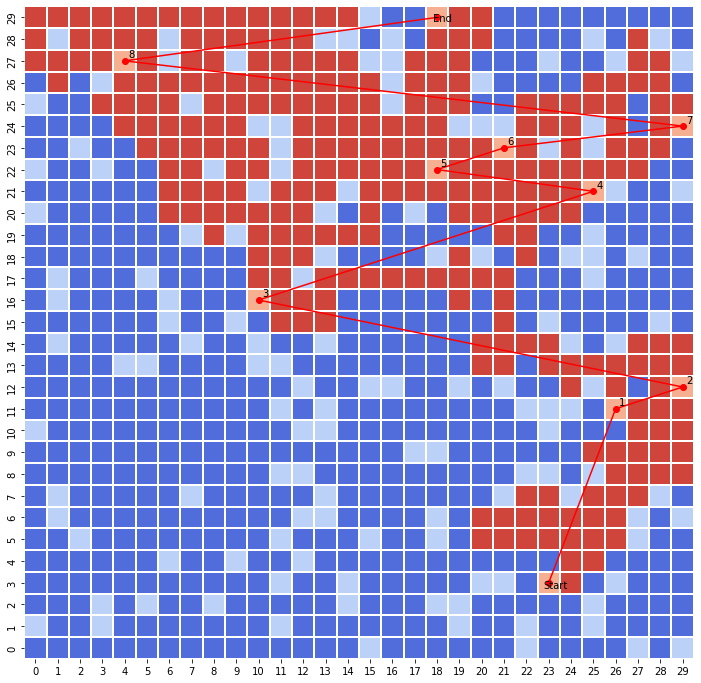

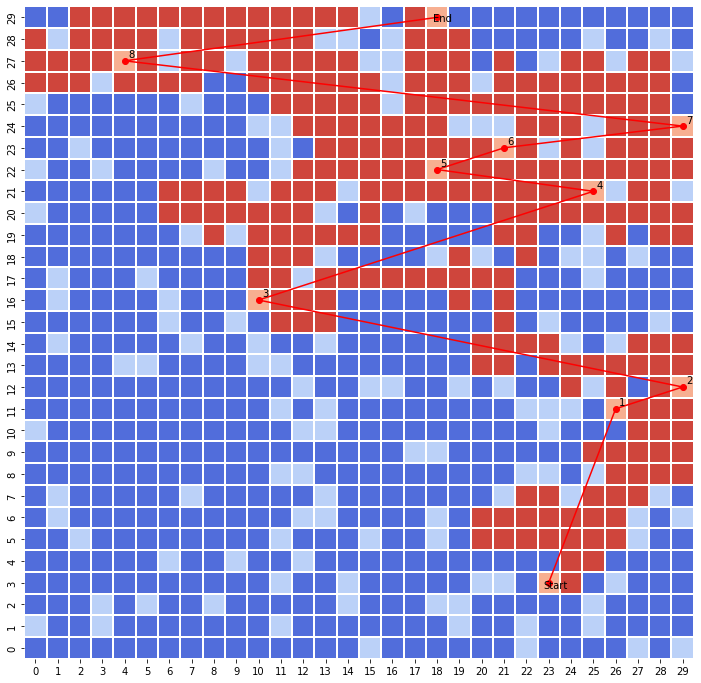

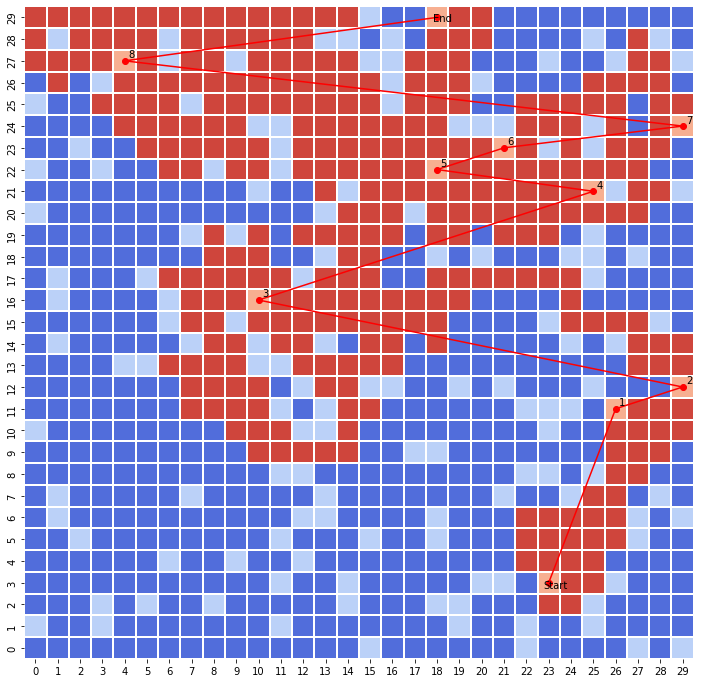

In [ ]:
map.visualizeIndividual(mappa,best_individual[0])